# PROJET EVASION

##### Francois Beauvois AKA CyberChinois
##### Nabil Boukraa AKA Devil
##### Sofianne Kasm AKA Ghost 
##### Victor Costa AKA DataNinja

Notebook created by V.Costa 4/4/2019

Last modification : none by none

Nota benne : 

Ce notebook est pour expliquer les raisonements utilisées. 

Le code original est originalement devellopé sur spider.

La version la plus abouti du code sera toujours dans le main.py et pas ici.

Pour la nomenclature, j'ai 2 regles: commencer par un "l" si c'est une variable local et par "a" si c'est un argument qui vient de l'exterieur. J'avoue que je ne la respecte pas toujours...

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Avant de commencer je crée des routines qui vont etre utiles par la suite.

#### Routine myWriteCSV 
pour ecrire les frames selectionnées au format csv. En realité ce n'est pas un csv (library csv non utilisé) mais je l'enregistre comme ça pour une question de facilité.

In [2]:
def myWriteCSV(aFullFileName,aListeResultats):
#Inputs : aFullFileName - nom du fichier à créer avec le full path
#       : aListeResults - liste avec les numeros à ecrire
    
    with open(aFullFileName, 'w') as output:
        [output.write(str(x) + "\n") for x in aListeResultats]
    output.close()

#### Routine myLoadImage 
pour lire les images qui composent la video et retouner une liste.

In [4]:
def myLoadImage(aFullPath,aFileName,aTypeColor='gris',abreak=None):
#Inputs : aFullPath - full path
#       : aFileName - nom du fichier qui contient les images à lire
#       : aTypeColor - type de structure de couleur souhaité (RGB,HSV ou gris)
#       : abreak - limite maximale d'images à extraire
#Output : lDecomposition - liste avec 3 dimensions (dimX, dimY, 3 channels pour la couleur)

    lDecomposition=[]
    lcount=1
    f = open(aFullPath + aFileName, 'rt')
    
    #ecrit comme ça pour minimiser des calculs/evaluations au sein d'une boucle
    if aTypeColor == 'RGB':
        for line in f:
           lDecomposition.append(cv2.imread(aFullPath+line.split()[0]))
           lcount+=1
           if lcount == abreak:
               break
    
    if aTypeColor =='HSV':
        for line in f:
           lDecomposition.append(cv2.imread(aFullPath+line.split()[0],cv2.COLOR_BGR2HSV))
           lcount+=1
           if lcount == abreak:
               break
         
    if aTypeColor =='gris':
        for line in f:
           lDecomposition.append(cv2.imread(aFullPath+line.split()[0],cv2.COLOR_BGR2GRAY))   
           lcount+=1
           if lcount == abreak:
               break
  
    f.close()
    return lDecomposition

#### Routine myEvaluation 
pour calculer la precision et recall par rapport au gold standart. Je l'ai crée à partir des anotations et je l'ai complété manuellement avec l'intro.

In [5]:
def myEvaluation(aRep,aListeResultats):
#Inputs : aRep - full path
#       : aListeResultats - liste generique avec 1 seule dimension qui contient notre prediction
#Output : precision et recall

    #lecture
    GoldList=[]
    with open(aRep + 'goldResult.csv', encoding="utf-8") as f:
        for line in f:
            GoldList.append(int(line))
    f.close
    
    #initialisation
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    #evaluation
    for key in aListeResultats:
        if key in GoldList:
            true_pos += 1
        else:
            false_pos += 1
    
    for key in GoldList:
        if key not in aListeResultats:
            false_neg += 1
    
    #calcul indicateurs
    if true_pos + false_pos != 0:
        precision = float(true_pos) / (true_pos + false_pos) * 100.0
    else:
        precision = 0.0
    
    if true_pos + false_neg != 0:
        recall = float(true_pos) / (true_pos + false_neg + false_pos) * 100.0
    else:
        recall = 0.0
        
    return precision, recall

#### Routine myLissage 
pour lisser l'image et ainsi reduire le bruit

In [6]:
def myLissage(aList,aNbImagesLissage=5):
#Inputs : aList - liste generique avec 1 seule dimension qui contient notre prediction
#       : aNbImagesLissage - sur combien d'images on realise la moyenne
#Output : ListLisse - nouvelle liste avec le lissage
    
    #utiliser nombre impair
    ListLisse=[]
    
    #first images
    for i in range(0,int((aNbImagesLissage-1)/2)):
        ListLisse.append(aList[i]) 
    
    for i in range(1,len(aList)-int((aNbImagesLissage-1)/2)):
        valeur=0.0    
        for j in range(int(-(aNbImagesLissage-1)/2),int((aNbImagesLissage-1)/2+1)):
            valeur+=aList[i+j]
        ListLisse.append(valeur/aNbImagesLissage)
    
    #last images
    for i in range(-int((aNbImagesLissage-1)/2),0):
        ListLisse.append(aList[i]) 

    return ListLisse

#### Routine myCutOff
pour selectionner les images à partir d'un seuil (cutoff)

In [39]:
def myCutOff(aCutOff,aList):
#Inputs : aCutoff - entier avec le niveau de seuil
#       : aList - liste generique avec 1 seule dimension qui contient un des traiments
#Output : lResult - liste avec les images qui ont été selectionées
  
    lResult=[]
    for i in range(len(aList)):
        if abs(aList[i]) > aCutOff:
            lResult.append(i)
    return lResult

# Modelisation

In [7]:
#Gestion des paths pour garantir que ça ne pete pas.
#Si vous saviez faire ça correctement, merci de partager l'info

path = r"C:\Users\vicks\Documents\Ecole\Multimedia\data\\"
RepCode=r"C:\Users\vicks\Documents\Ecole\Multimedia\evasion\\"
os.chdir(path)
RepImages=(path)

## Le gris

In [11]:
#load
dbgris = myLoadImage(RepImages,'listfull.txt','gris')

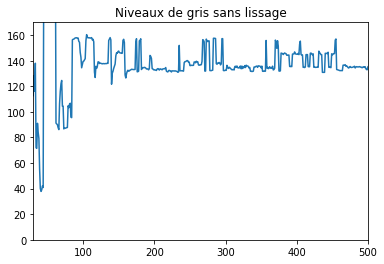

In [13]:
#traitement 1 : la moyenne
niv_gris_avg =[np.mean(x) for x in dbgris]

#visu des 500 premiers
plt.axis([30, 500, 0, 170])  #ici on change les axes
plt.title('Niveaux de gris sans lissage')
plt.plot(niv_gris_avg)
plt.show()

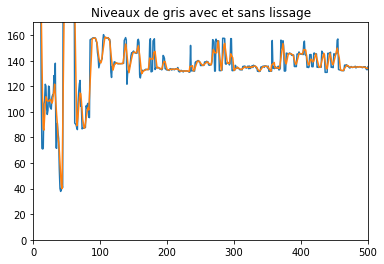

In [14]:
#lissage de la moyenne (utiliser nombre impair)
# 5 semble etre un bon compromis. 3 c'est bien aussi.
niv_gris_avg_liss=myLissage(niv_gris_avg,5)

#visu
plt.axis([0, 500, 0, 170])
plt.title('Niveaux de gris avec et sans lissage')
plt.plot(niv_gris_avg)
plt.plot(niv_gris_avg_liss)
plt.show()

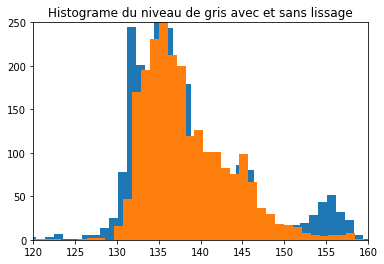

In [30]:
#histogramme avec lissage
plt.hist(niv_gris_avg,200)  # 200 tranches
plt.hist(niv_gris_avg_liss,200)  # 200 tranches
plt.title('Histograme du niveau de gris avec et sans lissage')
plt.axis([120, 160, 0, 250])
plt.show()

In [34]:
#calcul de la derivé (en pratique, c'est juste la difference)
derive_niv_gris_avg=[]
derive_niv_gris_avg.append(0) #fist element
for i in range(1,len(niv_gris_avg_liss)-1):
    derive_niv_gris_avg.append(niv_gris_avg_liss[i]-niv_gris_avg_liss[i-1])
derive_niv_gris_avg.append(0) #last element

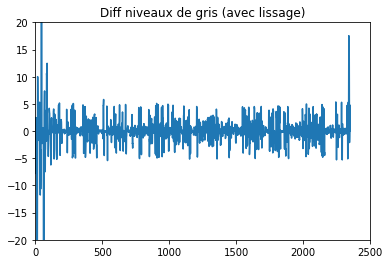

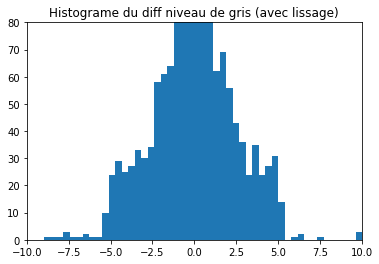

In [36]:
#graphs
plt.axis([0, 2500, -20, 20])
plt.title('Diff niveaux de gris (avec lissage)')
plt.plot(derive_niv_gris_avg)
plt.show()

#histogramme
plt.hist(derive_niv_gris_avg,200)
plt.title('Histograme du diff niveau de gris (avec lissage)')
plt.axis([-10, 10, 0, 80])
plt.show()

Ce dernier histogramme montre que un seuil entre 20 et 30 doit le faire (lire sur l'axe des Y). On veut seuiller où les diffs sont grands.

Alons tester 30.

In [42]:
myResult=myCutOff(30,derive_niv_gris_avg)
precision, recall = myEvaluation(RepCode,myResult)
print(precision)
print(recall)

23.076923076923077
0.5736137667304015


Faisons ça en automatique.

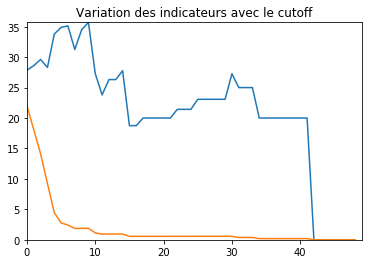

Best seuil : 9
Best precision:  35.714285714285715
Recall of best precision: 1.8832391713747645


In [54]:
liste_precision=[]
liste_recall=[]
liste_myResult=[]

for i in range(1,50): #teste entre 1 et 50 en seuille
    liste_myResult=myCutOff(i,derive_niv_gris_avg)
    
    lprecision, lrecall = myEvaluation(RepCode,liste_myResult)
    liste_precision.append(lprecision)
    liste_recall.append(lrecall)
    
#visu
plt.axis([0, len(liste_precision), 0, 
          max(max(liste_precision),max(liste_recall))])
plt.title('Variation des indicateurs avec le cutoff')
plt.plot(liste_precision)
plt.plot(liste_recall)
plt.show()

#max
CutoffOptimal=liste_precision.index(max(liste_precision))
print('Best seuil :',CutoffOptimal)
print('Best precision: ' , max(liste_precision))
print('Recall of best precision:',liste_recall[CutoffOptimal])

Attention : il faut prendre x+1 car le graphique commence à 0.


Alons simuler et enregistrer ce cas pour le voir avec l'outil excel myTreatment.xlsm :

In [58]:
myResult=myCutOff(10,derive_niv_gris_avg) #x+1
precision, recall = myEvaluation(RepCode,myResult)
print (precision, recall)

35.714285714285715 1.8832391713747645


In [59]:
myWriteCSV(RepCode+'myResult.csv',myResult)  #ne pas changer le nom